In [ ]:
#!pip install stackstac && pip install pystac_client && pip install geogif
#!pip install numpy && pip install matplotlib
#!pip install python-dotenv
import pystac_client
import geogif
import stackstac
import os
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

In [10]:
load_dotenv()

os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')

# Other variables
os.environ['GDAL_HTTP_TCP_KEEPALIVE'] = "YES"
os.environ['AWS_S3_ENDPOINT'] = "eodata.dataspace.copernicus.eu"
os.environ['AWS_HTTPS'] = "YES"
os.environ['AWS_VIRTUAL_HOSTING'] = "FALSE"
os.environ["GDAL_HTTP_UNSAFESSL"] = "YES"

In [11]:
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

In [12]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [19.85, 50.00],
            [20.10, 50.00],
            [20.10, 50.15],
            [19.85, 50.15],
            [19.85, 50.00],
        ]
    ],
}

In [13]:
params = {
    "max_items": 100,
    "collections": "sentinel-2-l2a",
    "datetime": "2024-02-01/2024-04-09",
    "intersects": geom,
    "query": {"eo:cloud_cover": {"lte": 20}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]},
}

In [14]:
items = list(cat.search(**params).items_as_dicts())

In [15]:
stack = stackstac.stack(
    items=items,
    resolution=(10, 10),
    bounds_latlon=(19.85, 50.00, 20.10, 50.15),
    chunksize=98304,
    epsg=32634,
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
        {
            "GDAL_NUM_THREADS": -1,
            "GDAL_HTTP_UNSAFESSL": "YES",
            "GDAL_HTTP_TCP_KEEPALIVE": "YES",
            "AWS_VIRTUAL_HOSTING": "FALSE",
            "AWS_HTTPS": "YES",
        }
    ),
)

In [16]:
rgb = stack.sel(band=["B04_10m", "B03_10m", "B02_10m"])
B08 = stack.sel(band="B08_10m")
B04 = stack.sel(band="B04_10m")

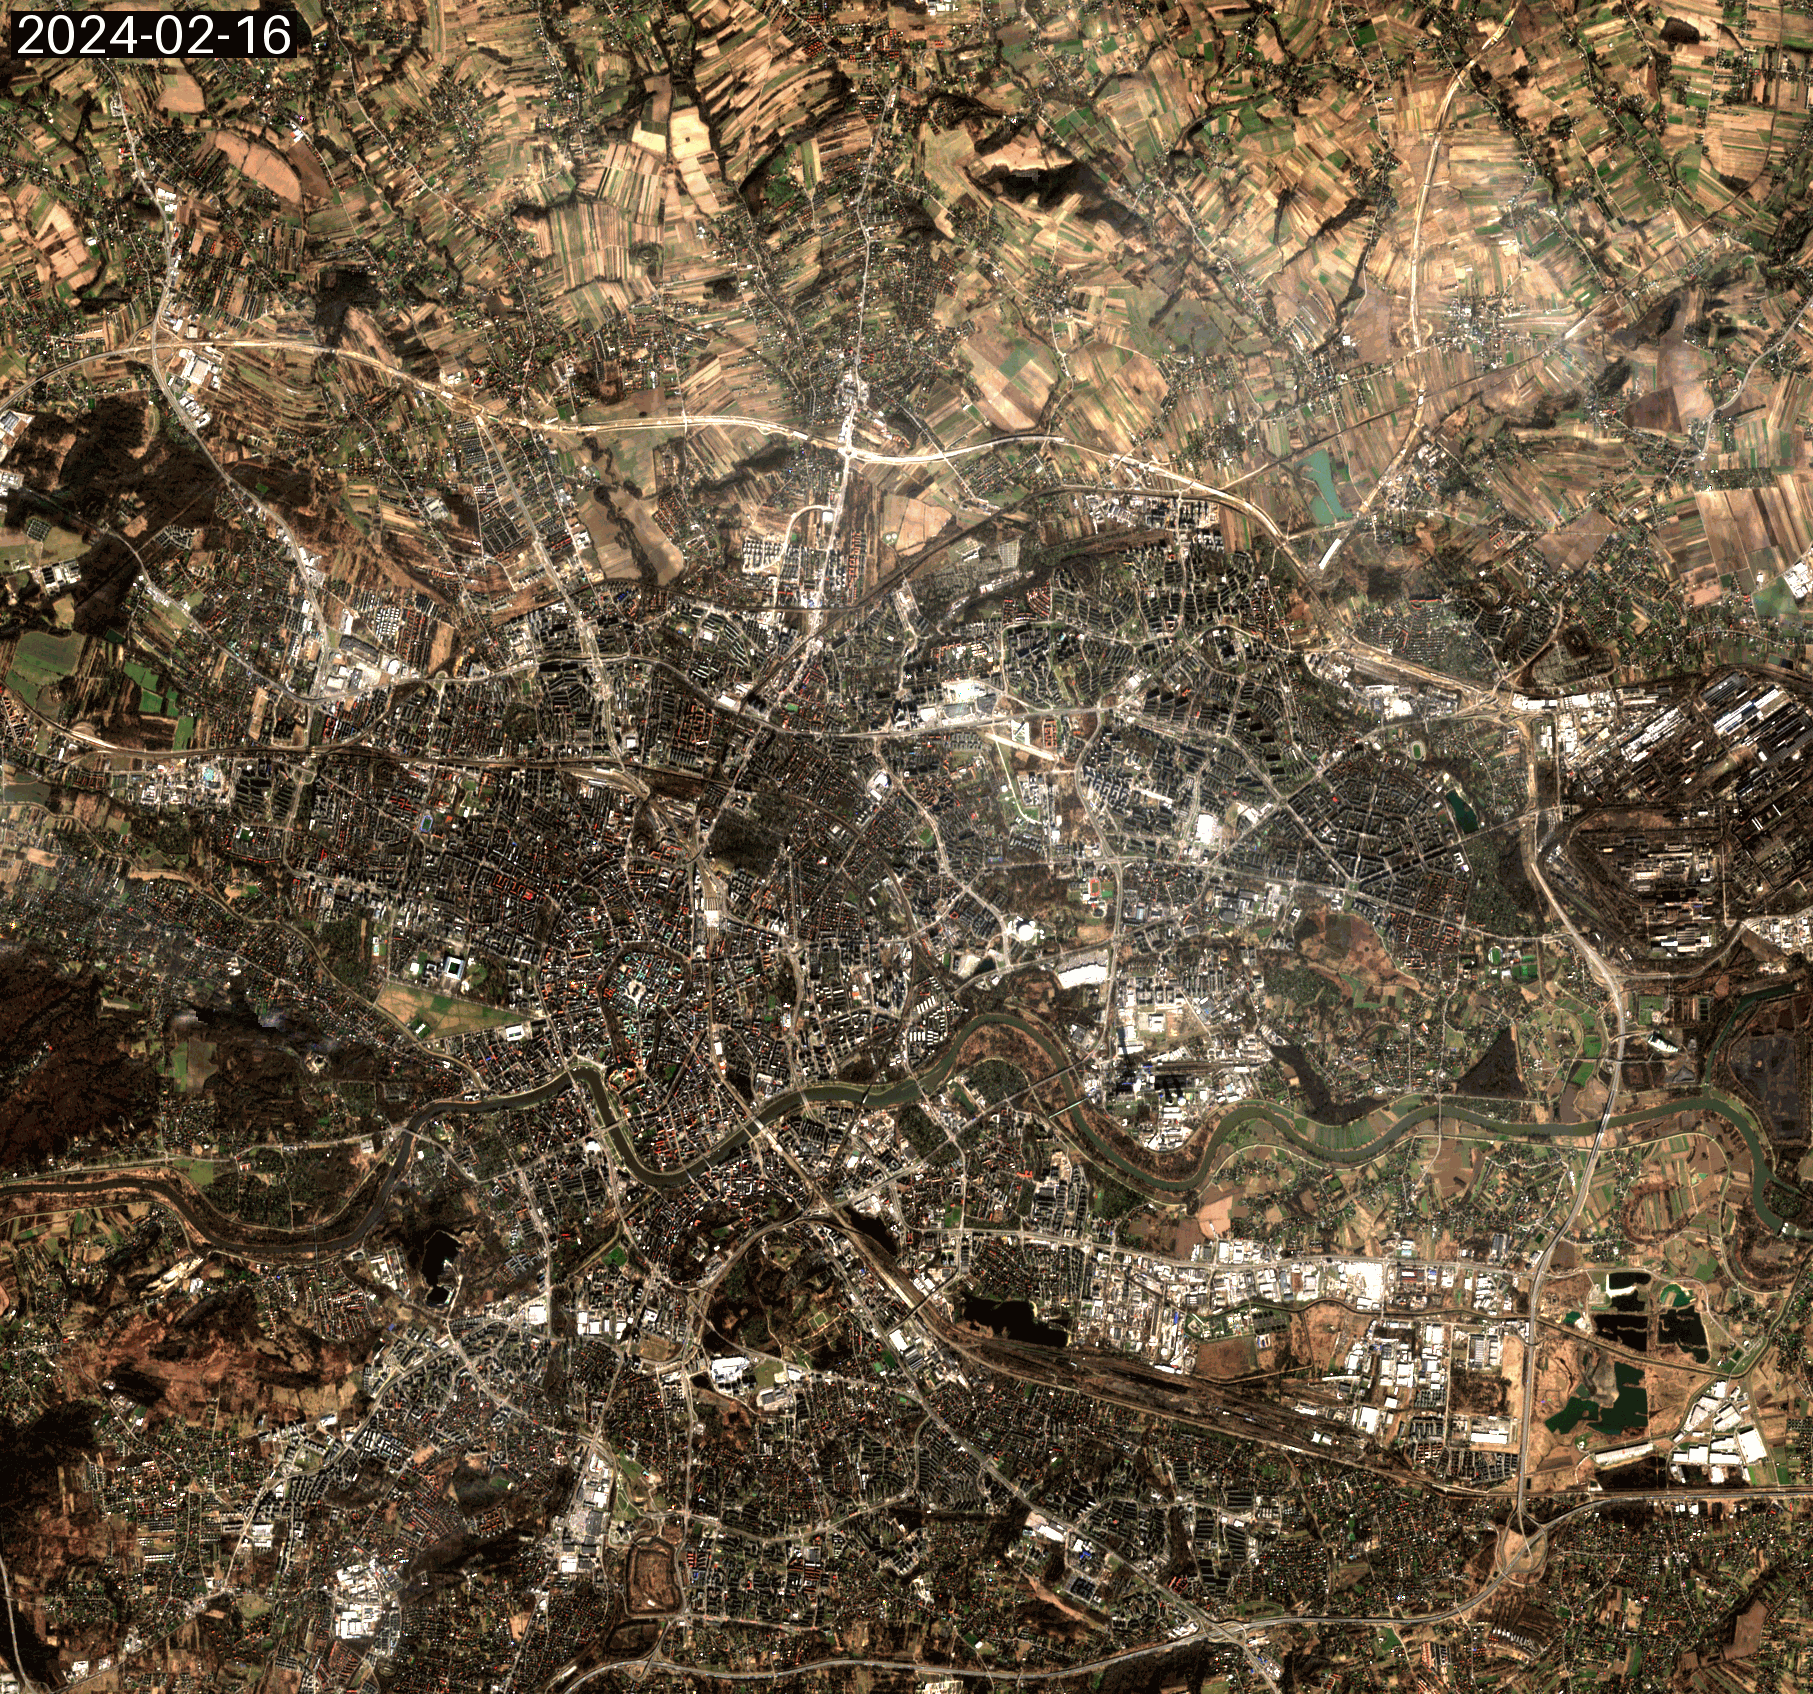

In [17]:
gif = geogif.dgif(rgb, fps=1).compute()
gif

In [18]:
cloud_cover_values = [item["properties"]["eo:cloud_cover"] for item in items]
cloud_cover_values

[2.65, 12.19, 19.52]

In [19]:
ndvi = (B08 - B04) / (B08 + B04)
print(ndvi['time'].values)
len(ndvi['time'])

['2024-02-16T09:50:29.024000000' '2024-03-27T09:46:19.025000000'
 '2024-03-29T09:40:31.024000000']


3

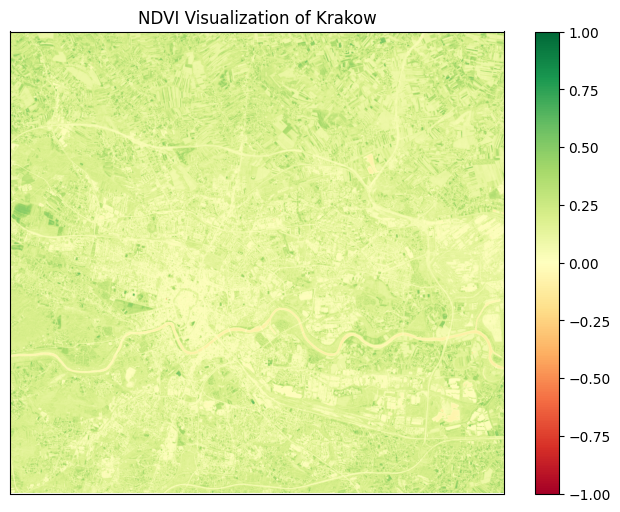

In [20]:
ndvi_single_layer = ndvi.isel(time=0)
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_single_layer, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar()
plt.title("NDVI Visualization of Krakow")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Synchronizacja plików z katalogu output_cog z bucketem S3
cog='s3cmd sync /home/eouser/Desktop/wisla/output_ndci/ s3://ndci_w'

os.system(cog)